In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-04-27 19:49:00 (KST = GMT+0900) 


0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.7.0
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.23.2
5 scipy      1.10.1
6 matplotlib 3.7.1
7 astroquery 0.4.7.dev8438
8 photutils  1.6.1.dev103+gad22185f
9 version_information 1.0.4


In [2]:
# %matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path

import numpy as np

from astropy import units as u
from astropy.nddata import CCDData, Cutout2D
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.stats import sigma_clipped_stats

from astroquery.mast import Catalogs

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams.update({'font.size':12})

from photutils.aperture import (CircularAperture, CircularAnnulus, 
                                aperture_photometry, ApertureStats)
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DAOGroup

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import _tool_visualization as vis

DATAPATH = Path('../../Tutorial_Data')
TMPDIR = Path('tmp')
TMPDIR.mkdir(exist_ok=True)

allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

ccd = CCDData.read(allfits[0])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
pix_scale = 0.4*u.arcsec
center_xy = np.array(ccd.shape)/2
center_radec = ccd.wcs.wcs_pix2world(*center_xy, 0)
center_coo = SkyCoord(*center_radec, unit='deg')
fov_radius = np.sqrt((np.array(ccd.shape)**2).sum())/2 * pix_scale
q_ps = Catalogs.query_region(center_coo, radius=fov_radius, catalog="Panstarrs", 
                             data_release="dr2", table="mean")
# Change some column names for convenience.
q_ps["raMean"].name = "ra"
q_ps["decMean"].name = "dec"
q_ps["gMeanPSFMag"].name = "g"
q_ps["rMeanPSFMag"].name = "r"

# drop stars with unknown magnitudes
q_ps = q_ps.to_pandas().dropna(subset=["g", "r"])

# Calculate V and R
q_ps["V"] = 0.006 + 0.474*q_ps["g"] + 0.526*q_ps["r"]
q_ps["R"] = -0.138 - 0.131*q_ps["g"] + 1.131*q_ps["r"]
q_ps["dV"] = np.sqrt(
    0.474**2*q_ps["gMeanPSFMagErr"]**2 
    + 0.526**2*q_ps["rMeanPSFMagErr"]**2 + 0.012**2
)
q_ps["dR"] = np.sqrt(
    0.131**2*q_ps["gMeanPSFMagErr"]**2
    + 1.131**2*q_ps["rMeanPSFMagErr"]**2 + 0.015**2
)

# Select only important columns
q2 = q_ps[["ra", "dec", "g", "r", "V", "R", "dV", "dR"]].copy().reset_index(drop=True)

# Select only brighter than 22 mag
q2 = q2[(q2["V"] < 22) & (q2["R"] < 22)].copy()

# Calculate x, y position
coo = SkyCoord(q2["ra"], q2["dec"], unit='deg')
q2["x"], q2["y"] = ccd.wcs.wcs_world2pix(coo.ra, coo.dec, 0)

# Remove stars outside the image
q2 = q2[(q2["x"] > 20) & (q2["x"] < ccd.shape[1]-20) 
        & (q2["y"] > 20) & (q2["y"] < ccd.shape[0]-20)]

q2 = q2.reset_index(drop=True)

print(f"Total {len(q2)} stars from PS1 DR2")

Total 122 stars from PS1 DR2


In [4]:
    
def group_stars(table, crit_separation, xcol="x", ycol="y", index_only=True):
    ''' Group stars using DAOGROUP algorithm and return row indices.

    Parameters
    ----------
    table : astropy.table.Table
        The queried result table.

    crit_separation : float or int
        Distance, in units of pixels, such that any two stars separated by less
        than this distance will be placed in the same group.

    xcol, ycol : str, optional
        The column names for x and y positions. This is necessary since
        `~photutils.DAOGroup accepts a table which has x y positions designated
        as ``"x_0"`` and ``"y_0"``.

    index : bool, optional
        Whether to return only the index of the grouped rows (group information
        is lost) or the full grouped table (after group_by).

    Notes
    -----
    Assuming the psf fwhm to be known, ``crit_separation`` may be set to
    ``k * fwhm``, for some positive real k.

    See Also
    --------
    photutils.DAOStarFinder

    References
    ----------
    [1] Stetson, Astronomical Society of the Pacific, Publications,
        (ISSN 0004-6280), vol. 99, March 1987, p. 191-222.
        Available at: http://adsabs.harvard.edu/abs/1987PASP...99..191S

    Return
    ------
    gtab: Table
        Returned when ``index_only=False``. The table underwent
        ``.group_by("group_id")``.

    grouped_rows: list
        Returned when ``index_only=True``.
        The indices of the rows which are "grouped" stars. You may remove such
        rows using ``table.remove_rows(grouped_rows)``.
    '''

    # Convert to astropy.Table because DAOGroup only accepts astropy.Table.
    if not isinstance(table, Table):
        table = Table.from_pandas(table)
    tab = table.copy()

    tab[xcol].name = "x_0"
    tab[ycol].name = "y_0"
    try:
        gtab = DAOGroup(crit_separation=crit_separation)(tab)
    except IndexError:  # empty tab (len(tab) == 0)
        gtab = tab
        gtab["group_id"] = []
        gtab["id"] = []

    if not index_only:
        gtab["x_0"].name = xcol
        gtab["y_0"].name = ycol
        return gtab
    else:
        gid, gnum = np.unique(gtab["group_id"], return_counts=True)
        gmask = gid[gnum != 1]  # group id with > 1 stars
        grouped_rows = []
        for i, gid in enumerate(gtab["group_id"]):
            if gid in gmask:
                grouped_rows.append(i)
        return grouped_rows


rows2rm = group_stars(q2, crit_separation=15) 
q2_close = q2.drop(rows2rm, axis=0).reset_index(drop=True)

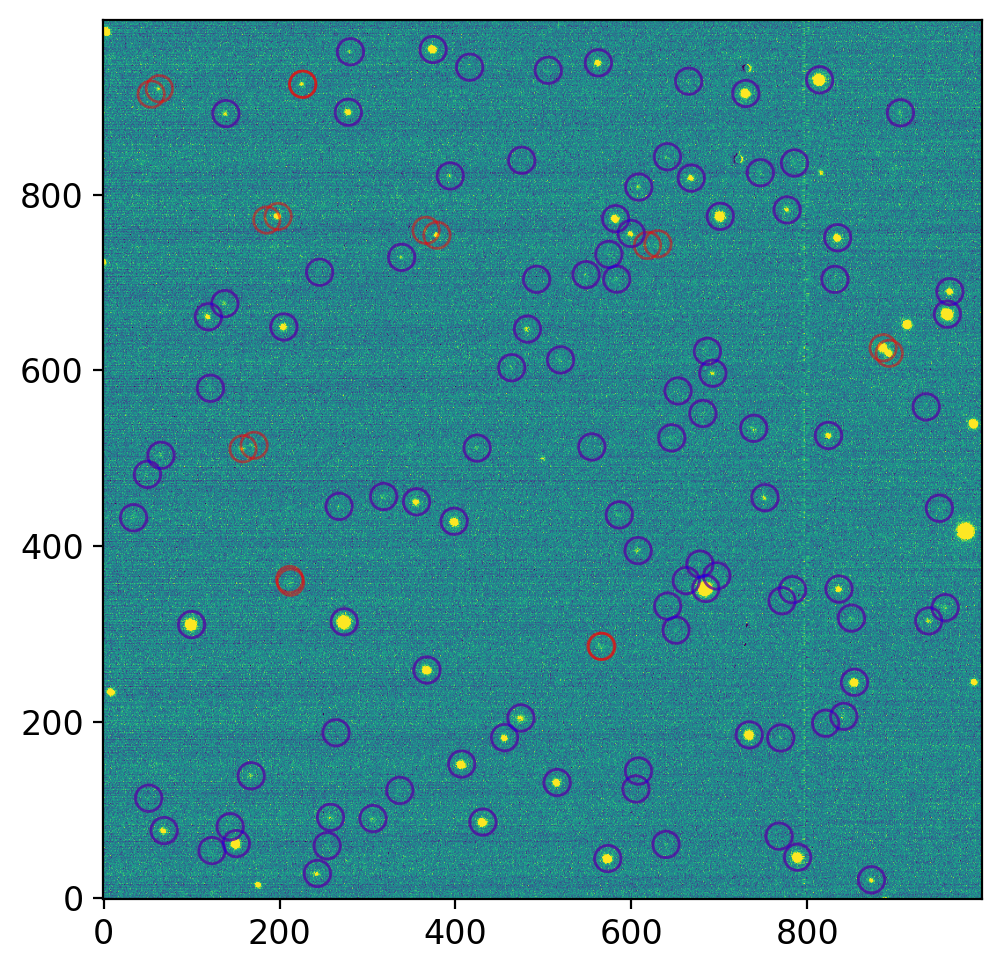

In [5]:
from photutils.utils import make_random_cmap


fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

aps_all = CircularAperture(np.array([q2["x"], q2["y"]]).T, r=15)
aps_close = CircularAperture(np.array([q2_close["x"], q2_close["y"]]).T, r=15)

vis.norm_imshow(axs, ccd.data, zscale=True)

aps_all.plot(color="r", lw=1, alpha=0.5, ax=axs)
aps_close.plot(color="blue", lw=1, alpha=0.5, ax=axs)

plt.tight_layout()
plt.show();

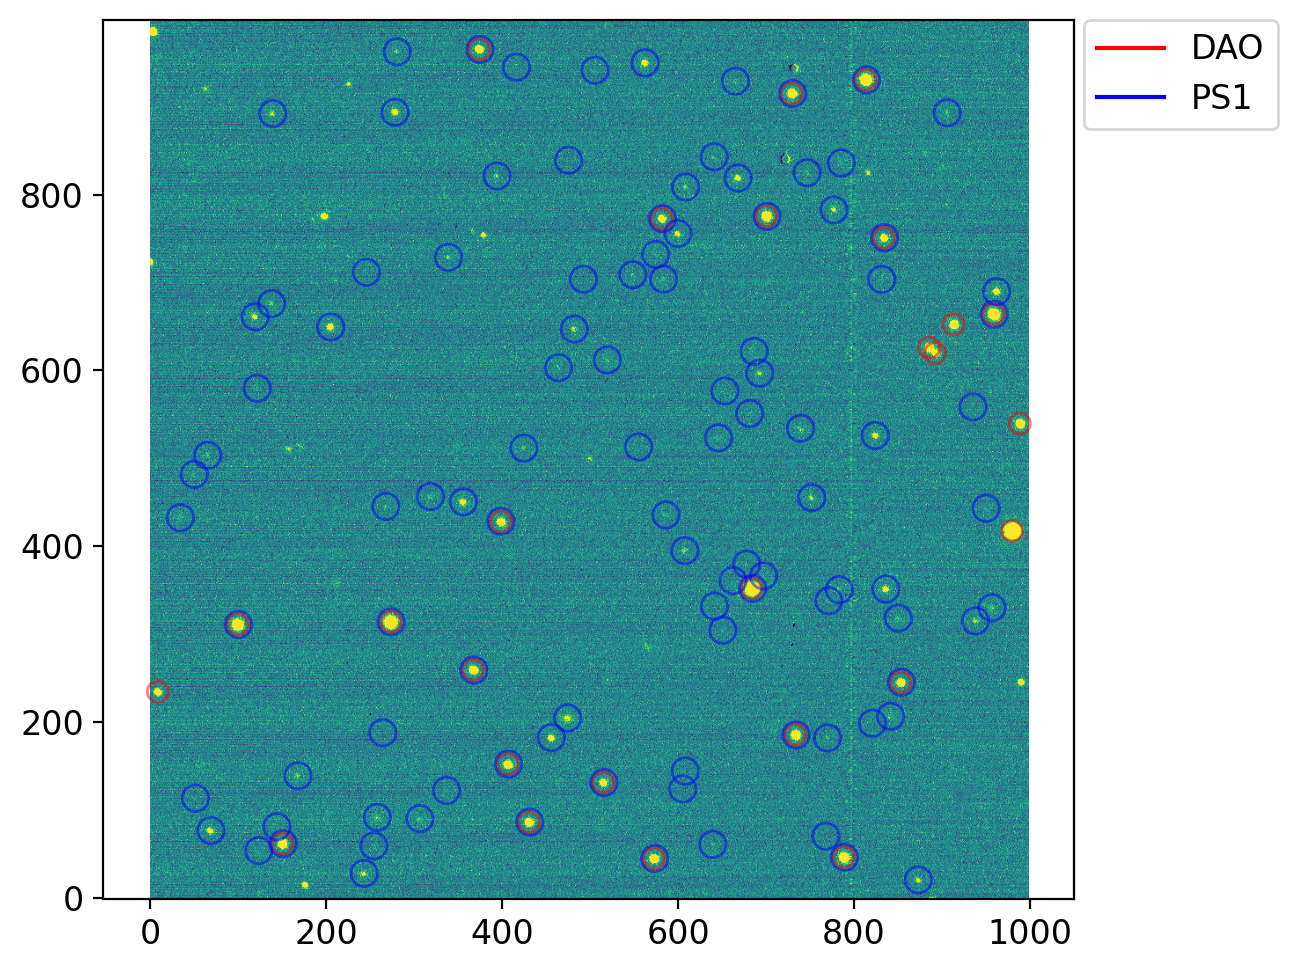

In [6]:
avg, med, std = sigma_clipped_stats(ccd.data)  # by default, 3-sigma 5-iteration.
finder = DAOStarFinder(
    fwhm=4,  # In reality, FWHM must be measured a priori using, e.g., `ginga`
    threshold=med + 3*std,  
    sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
    roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
    sigma_radius=1.5,           # default values 1.5
    ratio=1.0,                  # 1.0: circular gaussian
    exclude_border=True         # To exclude sources near edges
)

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
dao = finder(ccd.data - med)  

# Plot
aps_dao = CircularAperture(np.array((dao['xcentroid'], dao['ycentroid'])).T, r=12)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, ccd.data, zscale=True)

aps_dao.plot(color="r", lw=1, alpha=0.5, ax=axs)
aps_close.plot(color="b", lw=1, alpha=0.5, ax=axs)
for c, l in zip("rb", ["DAO", "PS1"]):
    axs.plot([], [], c=c, label=l)
axs.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show();

In [7]:
q2["xcentroid"], q2["ycentroid"] = None, None

for i, row in q2.iterrows():
    x, y = row["x"], row["y"]
    # Find closest DAOStarFinder source with distance no larger than 5 pix
    dx = dao["xcentroid"] - x
    dy = dao["ycentroid"] - y
    candidate = dao[(abs(dx) < 5) & (abs(dy) < 5)]
    if len(candidate) == 0:
        continue

    # Find the closest one
    if len(candidate) > 1:
        candidate = candidate[np.argmin(np.hypot(dx, dy))]
    
    q2.loc[i, "xcentroid"] = candidate["xcentroid"][0]
    q2.loc[i, "ycentroid"] = candidate["ycentroid"][0]
q2 = q2.dropna(axis=0, subset="xcentroid").reset_index(drop=True)

In [8]:
q2_xy = np.array([q2["xcentroid"], q2["ycentroid"]]).T
ap_stars = CircularAperture(q2_xy, r=15)
an_stars = CircularAnnulus(q2_xy, r_in=25, r_out=40)
phot = ypu.apphot_annulus(ccd, ap_stars, an_stars)
phot

/Users/ysbach/Dropbox/github/ysphotutilpy/ysphotutilpy/apphot.py:222: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(_arr/gn + (rd/gn)**2)


id     xcenter     ycenter   aperture_sum  aperture_sum_err       msky  \
0    1  733.547061  185.894605   71470.035387        238.110076  82.376563   
1    2  683.597508  352.101837  136392.760171        311.886373  82.407311   
2    3  373.764952  965.134344   65226.060312        229.769284  81.742402   
3    4  430.401859   86.515537   67175.807489        232.405929  81.726792   
4    5  150.115318   61.996268   70023.568134        236.204077  83.255303   
5    6  892.299268  619.670416   72387.191745        239.310742  82.819189   
6    7  885.556744  625.926869   72651.213248        239.655262  82.698840   
7    8  852.939584  245.473062   66182.145899        231.065959  81.706707   
8    9  398.620622  428.022236   65748.790402        230.479131  81.776060   
9   10  834.097491  751.027191   63252.207636        227.068857  81.803967   
10  11  729.206564  915.123616   69710.866056        235.790007  82.014422   
11  12  514.852419  131.521974   62774.915369        226.411038  82.671745   
12  13  406.479358  152.466729   66600.138620        231.630574  81.069719   
13  14  366.732549  259.549851   66772.323515        231.862758  81.871730   
14  15  273.125382  314.137367  115958.765702        290.692045  81.811827   
15  16   99.222111  311.189173   90900.419683        262.374538  82.572888   
16  17  788.412659   46.575940   76600.926637        244.751333  81.328128   
17  18  572.527333   45.070703   69361.244224        235.326186  81.592074   
18  19  958.725500  664.115010   88884.033720        259.961838  82.691000   
19  20  700.397607  775.539269   74188.050809        241.650920  82.385732   
20  21  581.307564  772.715496   63518.942187        227.435650  82.612708   
21  22  813.201259  930.602666   91338.393044        262.895666  81.687375   

        ssky  nsky  nrej      aparea    source_sum  source_sum_err       mag  \
0   8.670854  3063     2  706.858347  13241.474572      331.422147 -5.859463   
1   8.512401  3053    13  706.858347  78142.464785      385.347580 -7.786840   
2   8.610517  2848    13  706.858347   7445.760983      324.347206 -5.234395   
3   8.674529  3051    10  706.858347   9406.542194      327.416861 -5.488197   
4   8.709273  3051    12  706.858347  11173.862623      330.769688 -5.675130   
5   8.962818  3005    59  706.858347  13845.756972      337.717415 -5.907914   
6   8.950035  3000    65  706.858347  14194.848237      337.722092 -5.934949   
7   8.739336  3056     8  706.858347   8427.078358      327.686574 -5.368814   
8   8.454653  3057     9  706.858347   7944.700118      321.943592 -5.304816   
9   8.770648  3053     9  706.858347   5428.390820      325.476314 -4.891300   
10  8.539157  3030    26  706.858347  11738.287248      327.321035 -5.728634   
11  8.540667  3061     9  706.858347   4337.702015      320.659197 -4.647771   
12  8.847015  3043    11  706.858347   9295.330824      330.118617 -5.475284   
13  8.564080  3059     9  706.858347   8900.607975      324.967361 -5.428171   
14  8.901953  3060     3  706.858347  58129.392803      374.855564 -7.465611   
15  8.707413  3054     6  706.858347  32533.084585      349.905311 -6.835435   
16  8.377113  3054     7  706.858347  19113.460368      330.919512 -6.257970   
17  8.480043  3051    14  706.858347  11687.205354      325.897831 -5.723899   
18  9.032735  3028    31  706.858347  30433.210205      353.910927 -6.762991   
19  8.692652  3053     8  706.858347  15953.008252      334.375445 -6.061728   
20  8.591939  3048    15  706.858347   5123.460245      322.348047 -4.828530   
21  8.193039  3054    12  706.858347  33596.990387      341.412697 -6.870373   

        merr         snr  bad  nbadpix  
0   0.027175   39.953499    0        0  
1   0.005354  202.784366    0        0  
2   0.047296   22.956143    0        0  
3   0.037792   28.729560    0        0  
4   0.032140   33.781398    0        0  
5   0.026483   40.998055    0        0  
6   0.025832   42.031151    0        0  
7   0.042219   25.716886    0        0  